In [43]:
import json
import tensorflow as tf
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [67]:
vocab_size = 10000
embedding_dim = 16
max_length = 100
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_size = 20000 # We will use 20K for training ad ~7K for testing

In [55]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sarcasm.json \
    -O sarcasm.json

--2021-06-11 21:53:38--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sarcasm.json
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.131.128, 64.233.161.128, 173.194.220.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.131.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5643545 (5.4M) [application/json]
Saving to: ‘sarcasm.json’

sarcasm.json        100%[===================>]   5.38M   410KB/s    in 14s     

2021-06-11 21:53:53 (395 KB/s) - ‘sarcasm.json’ saved [5643545/5643545]



In [56]:
with open("sarcasm.json", 'r') as f:
    datastore = json.load(f)

sentences = []
labels = []

for item in datastore:
    sentences.append(item['headline'])
    labels.append(item['is_sarcastic'])

In [57]:
print(sentences[:5])
print(labels[:5])

["former versace store clerk sues over secret 'black code' for minority shoppers", "the 'roseanne' revival catches up to our thorny political mood, for better and worse", "mom starting to fear son's web series closest thing she will have to grandchild", 'boehner just wants wife to listen, not come up with alternative debt-reduction ideas', 'j.k. rowling wishes snape happy birthday in the most magical way']
[0, 0, 1, 1, 0]


In [58]:
print(len(sentences))
print(len(labels))

26709
26709


In [68]:
training_sentences = sentences[0:training_size]
testing_sentences = sentences[training_size:]

training_labels = labels[0:training_size]
testing_labels = labels[training_size:]

# Converting labels to NumPy arrays
training_labels = np.array(training_labels)
testing_labels = np.array(testing_labels)

In [69]:
# Very beautiful code

tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)

word_index = tokenizer.word_index

training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [70]:
print(type(training_padded))
print(training_padded.shape)
print(type(training_labels))

# Level of transformations
print(training_sentences[0]) # Firstly, we had a sentence type="str"
print(training_sequences[0]) # Then tokenized all words in 27K with t.word_index, and with t.texts_to_sequences we see the integer repres of sent-s
print(training_padded[0]) # We see the final, which will go for training

<class 'numpy.ndarray'>
(20000, 100)
<class 'numpy.ndarray'>
former versace store clerk sues over secret 'black code' for minority shoppers
[328, 1, 799, 3405, 2404, 47, 389, 2214, 1, 6, 2614, 8863]
[ 328    1  799 3405 2404   47  389 2214    1    6 2614 8863    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0]


In [71]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation="relu"),
    tf.keras.layers.Dense(1, activation="sigmoid"),
])
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [72]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 100, 16)           160000    
_________________________________________________________________
global_average_pooling1d_8 ( (None, 16)                0         
_________________________________________________________________
dense_16 (Dense)             (None, 24)                408       
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 25        
Total params: 160,433
Trainable params: 160,433
Non-trainable params: 0
_________________________________________________________________


In [73]:
print(type(training_labels))

<class 'numpy.ndarray'>


In [74]:
num_epochs = 30
history = model.fit(training_padded, training_labels, epochs=num_epochs, validation_data=(testing_padded, testing_labels), verbose=2)

Epoch 1/30
625/625 - 1s - loss: 0.6772 - accuracy: 0.5698 - val_loss: 0.6352 - val_accuracy: 0.8024
Epoch 2/30
625/625 - 0s - loss: 0.4658 - accuracy: 0.8148 - val_loss: 0.3937 - val_accuracy: 0.8374
Epoch 3/30
625/625 - 0s - loss: 0.3241 - accuracy: 0.8705 - val_loss: 0.3586 - val_accuracy: 0.8463
Epoch 4/30
625/625 - 0s - loss: 0.2702 - accuracy: 0.8966 - val_loss: 0.3474 - val_accuracy: 0.8489
Epoch 5/30
625/625 - 0s - loss: 0.2327 - accuracy: 0.9106 - val_loss: 0.3466 - val_accuracy: 0.8572
Epoch 6/30
625/625 - 0s - loss: 0.2063 - accuracy: 0.9202 - val_loss: 0.3588 - val_accuracy: 0.8508
Epoch 7/30
625/625 - 0s - loss: 0.1842 - accuracy: 0.9293 - val_loss: 0.3555 - val_accuracy: 0.8541
Epoch 8/30
625/625 - 0s - loss: 0.1640 - accuracy: 0.9395 - val_loss: 0.3820 - val_accuracy: 0.8484
Epoch 9/30
625/625 - 0s - loss: 0.1487 - accuracy: 0.9460 - val_loss: 0.4026 - val_accuracy: 0.8450
Epoch 10/30
625/625 - 0s - loss: 0.1356 - accuracy: 0.9499 - val_loss: 0.4096 - val_accuracy: 0.8466

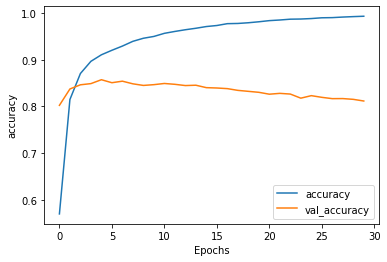

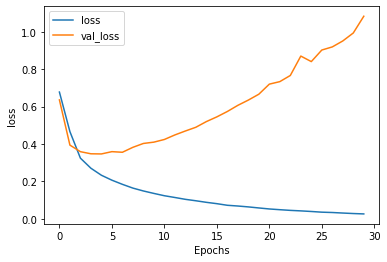

In [75]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])

  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [76]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape) # shape: (vocab_size, embedding_dim)

(10000, 16)


In [78]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_sentence(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

print(decode_sentence(training_padded[0]))
print(training_sentences[2])
print(labels[2])

former <OOV> store clerk sues over secret 'black <OOV> for minority shoppers ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ?
mom starting to fear son's web series closest thing she will have to grandchild
1


In [79]:
import io

out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')
for word_num in range(1, vocab_size):
  word = reverse_word_index[word_num]
  embeddings = weights[word_num]
  out_m.write(word + "\n")
  out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
out_v.close()
out_m.close()

In [86]:
sentence = ["granny starting to fear spiders in the garden might be real", "game of thrones season finale showing this sunday night"]

sequences = tokenizer.texts_to_sequences(sentence)
padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

np.set_printoptions(precision=5)
np.set_printoptions(suppress=True) # args: precision=3
print(model.predict(padded))

[[0.88514]
 [0.00001]]
